## Required Packages


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import callbacks
from sklearn.mixture import GaussianMixture
import time
import random
from sklearn import preprocessing as pp
from scipy import signal
import pickle
import sklearn

## Generate the dataset

In [2]:
def get_adjacency(sz,p,undirected):
    '''
    Generates a realization of an Erdős–Rényi Graph Model, undirected or directed.
    -First generates of matrix of random floating point numbers in the range [0.0, 1.0].
    -If those values are <=p then there is no edge between pairs
    -Makes the matrix symmetric if the graoh is undirected

        Parameters:
                sz (int): Number of nodes
                p (int): Probability of existing an edge between each pair of nodes

        Returns:
                adj (2darray): Adjacency matrix
    '''
    adj = np.random.random((sz, sz)) <= p
    adj = np.triu(adj.astype(int))
    np.fill_diagonal(adj,0)
    if(undirected):
        adj = adj + adj.T
    return adj

def get_A(adj,c,rho):
    '''
    Generates the connectivity matrix (interaction weights) from the adjacency matrix according to the laplacian rule

        Parameters:
                adj (2darray): Adjacency matrix
                c,rho (int): Numbers between 0 and 1, to make the spectral radius < 1

        Returns:
                A (2darray): Connectivity matrix
    '''    
    sz = len(adj)
    Dvec = np.sum(adj, axis=1)
    Dmax = np.max(Dvec)
    ccc = c*1/Dmax
    D = np.diag(Dvec)
    L = D - adj
    Ap = np.eye(sz) - ccc*L
    A = rho * Ap
    return A

def tsg(A,tsize,x0,qsi):
    '''
    Generates the syntetic time series data given the connectivity matrix and the initial condiction x(0), 
    according to the dynnamical rule y(n + 1) = Ay(n) + x(n + 1)

        Parameters:
                A (2darray): Connectivity matrix
                tsize (int): Time series size - number of samples
                x0 (int): Initial condition x(0), in this case is zero
                qsi (int): Noise standart deviation 

        Returns:
                x (2darray): Time series data of the graph
    ''' 
    sz = len(A)
    x = np.zeros((tsize,sz))
    
    x[0,:] = np.ones((1,sz))*x0
    for i in range(1,tsize):
      for j in range(sz):
        x[i,j] = np.dot(A[j,:],x[i-1,:]) + qsi*np.random.randn(1)
    return x


def granger(z):
    '''
    Granger Estimator

        Parameters:
                z (2darray): Time series of the observed nodes

        Returns:
                R1*inv(R0) (2darray): Estimated connectivity matrix
    '''   
    z=z.T
    tsize = z.shape[1]
    
    #0-lag correlation matrix
    R0=np.matmul(z,z.T)/tsize;

    #1-lag correlation matrix
    z1=z[:,2:tsize];
    z2=z[:,1:tsize-1];
    R1=np.matmul(z1,z2.T)/(tsize-1)

    #R1*inv(R0)
    return np.matmul(R1,np.linalg.inv(R0))

def r1_minus_r3(z):
    '''
    R1-R3(NIB) Estimator

        Parameters:
                z (2darray): Time series of the observed nodes

        Returns:
                R1-R3 (2darray): Estimated connectivity matrix
    '''   
    z = z.T
    tsize = z.shape[1]
    
    #1-lag correlation matrix
    z1=z[:,2:tsize];
    z2=z[:,1:tsize-1];
    R1=np.matmul(z1,z2.T)/(tsize-1)

    #3-lag correlation matrix
    z1=z[:,4:tsize];
    z2=z[:,1:tsize-3];
    R3=np.matmul(z1,z2.T)/(tsize-3);

    #(R1-R3)
    return (R1-R3)

def r1(z):
    '''
    R1 Estimator

        Parameters:
                z (2darray): Time series of the observed nodes

        Returns:
                R1 (2darray): Estimated connectivity matrix
    '''
    z = z.T
    sz = z.shape[0]
    tsize = z.shape[1]
    
    #1-lag correlation matrix
    z1=z[:,2:tsize];
    z2=z[:,1:tsize-1];
    R1=np.matmul(z1,z2.T)/(tsize-1)

    #id - inv(R1+R2+id) Estimator
    return R1


def plot_estimator_results(As,pred,method,estimator,undirected):
    '''
    Computes the estimators' performance metrics from their estimated matrix A

        Parameters:
                As (2darray): Ground truth matrix A
                pred (2darray): Estimated matrix A
                method (string): Clustering method to be applied
                estimator (string): Estimator type: granger, r1-r3 or r1

        Returns:
                R1 (1darray): Performance metrics (accuracy, identifiability gap)
    '''
    
    #Number of nodes
    sz = len(As)

    #Count the number of connected and disconnected pairs
    if(undirected):
        alln = int(sz*(sz-1)/2)
        tr = np.triu(As)
        np.fill_diagonal(tr,0)
        tr = tr>0
        tr=tr.astype(int)
        nc = np.sum(tr)
    else:
        alln = (sz*sz)-sz
        tr = As
        np.fill_diagonal(tr,0)
        tr = tr>0
        tr=tr.astype(int)
        nc = np.sum(tr)
        
    #Divide the pairs into connected and disconnected
    con = np.zeros((nc))
    dis = np.zeros((alln-nc))
    comp = np.zeros((2,alln))

    #Save data
    c1,c2,c3 = 0,0,0
    if(undirected):
        for i in range(sz):
            for j in range(i+1,sz):
                comp[0,c1] = As[i,j]
                comp[1,c1] = pred[i,j]
                c1=c1+1
                if(As[i,j]>0):
                    con[c2] = pred[i,j]
                    c2+=1
                else:
                    dis[c3] = pred[i,j]
                    c3+=1
    else:
        for i in range(sz):
            for j in range(sz):
                if(j!=i):
                    comp[0,c1] = As[i,j]
                    comp[1,c1] = pred[i,j]
                    c1=c1+1
                    if(As[i,j]>0):
                        con[c2] = pred[i,j]
                        c2+=1
                    else:
                        dis[c3] = pred[i,j]
                        c3+=1
                
    #Get the estimation performance metrics
    accuracy=cluster_pred(np.copy(comp[0,:]),np.copy(comp[1,:]),method,estimator)
    clvar,idgap=get_metrics(np.copy(comp[0,:]), np.copy(comp[1,:]), alln, nc)
    return np.array([accuracy,clvar,idgap])


def cluster_pred(true,pred,method,estimator):
    '''
    Clusters the estimators' results into two groups and classifies it into connected and disconnected

        Parameters:
                true (2darray): Ground truth matrix A
                pred (2darray): Estimated matrix A
                method (string): Clustering method to be applied
                estimator (string): Estimator type: granger, r1-r3 or r1

        Returns:
                accuracy (1darray): Accuracy of the estimations
    '''

    #Sort it
    idx = np.argsort(pred, axis=0)

    #Build a data structure for clustering
    features = np.zeros((len(pred),2))
    features[:,0] = np.linspace(0,1,len(pred))
    features[:,1] = pred[idx]
    
    #Clustering data with Gaussian Mixture Model or kmeans
    if(method=="gmm"):
        gmm = GaussianMixture(n_components=2)
        labels = gmm.fit_predict(features)
    elif(method=="kmeans"):
        kmeans = KMeans(n_clusters=2)
        labels = kmeans.fit_predict(features)

    #Unsort the values after clustering
    us = np.argsort(idx, axis=0)
    labels_unsorted = labels[us]
    cld = pred[np.where(labels_unsorted == 1)]
    clc = pred[np.where(labels_unsorted == 0)]

    #Disconnected pairs must be on cld and conneceed pairs on clc
    if(np.mean(cld)>np.mean(clc)):
        temp = cld
        cld=clc
        clc=temp
        labels_unsorted[:] = np.abs(labels_unsorted[:]-1)
        
    
    #Count the number of pairs correctly classified
    tcout = 0
    for i in range(len(labels_unsorted)):
        if((labels_unsorted[i]==1 and true[i]>0) or (labels_unsorted[i]==0 and true[i]==0)):
            tcout+=1
        
    #Compute accuracy
    accuracy = 100-(tcout/len(labels_unsorted)*100)
    return accuracy

def compare_estimators(As,z,undirected):
    '''
    This function computes the estimations (using the estimators) and their performance

        Parameters:
                As (2darray): Ground truth matrix A
                z (2darray): Matrix containing the time series of the observed nodes
                sigm (string): Clustering method to be applied
                estimator (string): Estimator type: granger, r1-r3 or r1

        Returns:
                data (1darray): Matrix containing the performance for the different 3 estimators
    '''
    #Granger
    pred = granger(z)
    metrics1 = plot_estimator_results(As,pred,"gmm",'G',undirected)
    
    #R1 minus R3
    pred = r1_minus_r3(z)
    metrics2 = plot_estimator_results(As,pred,'gmm','R13',undirected)

    #R1 Estimator
    pred = r1(z)
    metrics3 = plot_estimator_results(As,pred,'gmm','R12',undirected)

    data = np.zeros((3,3))  
    data[0,:] = metrics1
    data[1,:] = metrics2
    data[2,:] = metrics3
    return data

def get_metrics(true, pred, upper, nc):
    '''
    This function rescales the data and computes the performance metrics, this way the measurements are calculated using the 
    same scale

        Parameters:
                true (1darray): Ground truth matrix A
                pred (1darray): Estimated matrix A
                upper (int): Number of pairs of nodes
                nc (int): Number of connected pairs

        Returns:
                idgap (int): Identifiability gap
                clvar (int): Cluster Variance
    '''
    #Normalize the values
    pred = sklearn.preprocessing.minmax_scale(pred, feature_range=(0, 1), axis=0, copy=True)
    
    #Initialize the structures to save the data
    con = np.zeros((nc))
    dis = np.zeros((upper-nc))
    
    #Split the values belonging to connected and disconnected pairs
    c2,c3 = 0,0
    for i in range(len(true)):
        if(true[i]>0):
            con[c2] = pred[i]
            c2+=1
        else:
            dis[c3] = pred[i]
            c3+=1
    
    #Threshold
    mint = np.max(dis)
    maxt = np.min(con)
    threshold = np.ones((upper,))*((mint+maxt)/2)
    
    #Compute metrics
    clvar = (np.var(dis)+np.var(con))/2
    idgap = maxt - ((mint+maxt)/2)
    
    #If the id gap is negative then we cant correctly classify the pairs as disconnected or connected
    if(idgap < 0):
        idgap=0
    
    return clvar,idgap


def extract_cross_correlation(zz,n):
    '''
    Extracts the cross correlation from the feature

        Parameters:
                zz (1darray): Matrix with the observed node time series
                n (int): Number of nodes in the graph
        Returns:
                data_nn (2darray): Matrix containing a fecture vector for each pair of nodes
                y (1darray): Ground-truth
    '''
    tsize=zz.shape[0]
    upper = int(n*(n-1)/2)
    data_nn = np.zeros((200,upper))
    target = np.zeros((1,upper))

    counter = 0

    #Go through each pair and compute the time laged cross-correlation
    for j in range(n):
        for k in range(j+1,n):
            aux = signal.correlate(zz[:,j],zz[:,k], mode="full")
            data_nn[:,counter] = aux[tsize-100:tsize+100]
            target[0,counter] = A[j,k]
            counter = counter + 1

    data_nn = data_nn/np.max(data_nn)
    data_nn=data_nn.T

    y=target>0
    y=y.astype(int)+1

    y=y.T
    return data_nn,y
    
def plot_svm_results(model_name,data_nn,y):
    '''
    Loads a saved SVM model and classfies the features into connected or disconnected classes

        Parameters:
                model_name (string): Name of the saved model
                data_nn (1darray): Features of the observed models
                y (1darray): Ground-truth
        Returns:
                [per,clvar,idgap] (1darray): Performance of the SVM predictions
    '''
    loaded_model = pickle.load(open(model_name, 'rb'))
    pred = loaded_model.predict(data_nn)
    true = y.flatten()
    
    #Compute the metrics
    upper = int((se-ss)*((se-ss)-1)/2)
    tr = np.triu(As)
    np.fill_diagonal(tr,0)
    tr = tr>0
    tr=tr.astype(int)
    nc = np.sum(tr)
    clvar,idgap=get_metrics(np.copy(true-1), np.copy(pred), upper, nc)

    per=100-(sum(pred!=true)/len(pred)*100)
    return [per,clvar,idgap]

def load_model(name):
    '''
    Loads a saved SVM model

        Parameters:
                name (string): Name of the saved model
        Returns:
                model (keras.object):SVM Model
    '''
    return keras.models.load_model(name)

def plot_nn_results(model_name,data_nn,y):
    '''
    Loads a saved CNN model and classfies the features into connected or disconnected classes

        Parameters:
                model_name (string): Name of the saved model
                data_nn (1darray): Features of the observed models
                y (1darray): Ground-truth
        Returns:
                [accuracy_nn,clvar,idgap] (1darray): Performance of the CNN predictions
    '''
    #Loads the models
    model = load_model(model_name)

    #Divide the connected and disconnected pairs values
    idd = y < 2
    idd = np.squeeze(idd)

    idc = y > 1
    idc = np.squeeze(idc)

    #Reshape the data to 3 dimensions
    data_nn = data_nn.reshape((data_nn.shape[0], data_nn.shape[1], 1))

    #Predicts the weight of the connection and classifies the data
    dis_mpred = model.predict(data_nn[idd,:,:])
    truec_nn = np.sum(dis_mpred<1.5)
    con_mpred = model.predict(data_nn[idc,:,:])
    trued_nn = np.sum(con_mpred>1.5)

    tall = truec_nn + trued_nn

    accuracy_nn = tall/(len(dis_mpred)+len(con_mpred))*100

    #Compute the metrics
    upper = int((se-ss)*((se-ss)-1)/2)
    tr = np.triu(As)
    np.fill_diagonal(tr,0)
    tr = tr>0
    tr=tr.astype(int)
    nc = np.sum(tr)
    clvar,idgap=get_metrics(np.copy(y-1), np.copy(model.predict(data_nn)), upper, nc)
    return [accuracy_nn,clvar,idgap]
    
    
def save_pickles(name,comparison_data,sz_main,p):
    '''
    Saves the performance metrics of all estimators

        Parameters:
                comparison_data (2darray): Performance of different estimators over a range of number of samples
                sz_main (int): Number of observed nodes
                p (1darray): Probability of the Erdős–Rényi Graph Model
    '''
    output = open(name, 'wb')
    pickle.dump(comparison_data, output)
    output.close()

In [3]:
#Parameters
sz_main = 50
p = 0.6
c = 0.9
rho = 0.75
undirected = True
    
#Define the range of noise variance
qsi = 0.1
tsize = 125000
x0 = 0

## Monte Carlo Simulations


In [4]:
#Simulation parameters
nruns=10 #Number of runs
min_samples = 1000
max_samples=tsize
tssize = np.arange(round(min_samples/1000),round(max_samples/1000),step=5)  #Number of samples (time series size) for each test
nestimators = 6 #Number of estimators

In [5]:
'''
Makes several runs for given graph over a range of number of samples

-At each run a new adjancency and A matrix is generated for the Erdős–Rényi Graph Model previously defined and then the time
series are generated according to the dynamics defined
-To observe the performance of the estimators in function of the number of samples, the performance if measure over a range of 
number of samples
'''

#Allocate memory to save the performance data
comparison_data = np.zeros((len(tssize),nruns,nestimators*3))

#Make several runs
for i in range(nruns):
    #Generate an A matrix
    adj = get_adjacency(sz_main,p,undirected)
    A = get_A(adj,c,rho)

    #Generate the time series
    data2 = tsg(A,tsize,x0,qsi)
    
    for j in range(len(tssize)):
        data_aux=np.copy(data2)
        data=data_aux[0:(tssize[j]*1000),:]

        #Select the observable nodes
        ss = 0
        se = 20
        #Select the observable nodes nada
        z=data[:,ss:se]
        As = A[ss:se,ss:se]

        #Compare algebrical estimaros
        estimators_acc = compare_estimators(As,z,undirected)
        comparison_data[j,i,0:3] = np.array(estimators_acc[:,0])
        comparison_data[j,i,6:9] = np.array(estimators_acc[:,1])
        comparison_data[j,i,12:15] = np.array(estimators_acc[:,2])

        #Extract the cross-correlation
        data_nn,y = extract_cross_correlation(z,se-ss)

        #Plot svm results
        stats_svm=plot_svm_results("svm_model300.sav",data_nn,y)
        comparison_data[j,i,3] = np.array(stats_svm[0])
        comparison_data[j,i,9] = np.array(stats_svm[1])
        comparison_data[j,i,15] = np.array(stats_svm[2])

        #Plot cnn results
        stats_cnn = plot_nn_results("smodel300",data_nn,y)
        comparison_data[j,i,4] = np.array(stats_cnn[0])
        comparison_data[j,i,10] = np.array(stats_cnn[1])
        comparison_data[j,i,16] = np.array(stats_cnn[2])
    
    print(i,se)
    save_name='data_'+str(sz_main)+'_'+str(p)+'_comparison.pkl'
    save_pickles(save_name,comparison_data,sz_main,p)

6/6 [==============================] - 0s 27ms/step
0 20
6/6 [==============================] - 0s 27ms/step
1 20
3/3 [==============================] - 0s 32ms/step


6/6 [==============================] - 0s 26ms/step
2 20
6/6 [==============================] - 0s 28ms/step
3 20
4/4 [==============================] - 0s 25ms/step


6/6 [==============================] - 0s 28ms/step
4 20
6/6 [==============================] - 0s 30ms/step
5 20
6/6 [==============================] - 0s 28ms/step


6/6 [==============================] - 0s 28ms/step
6 20
6/6 [==============================] - 0s 25ms/step
7 20
3/3 [==============================] - 0s 16ms/step


6/6 [==============================] - 0s 28ms/step
8 20
6/6 [==============================] - 0s 31ms/step
9 20


## Results Analysis

In [6]:
def load_pickles(name):
    pkl_file = open(name, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

save_name='data_'+str(sz_main)+'_'+str(p)+'_comparison.pkl'
data=load_pickles(save_name)

### Accuracy

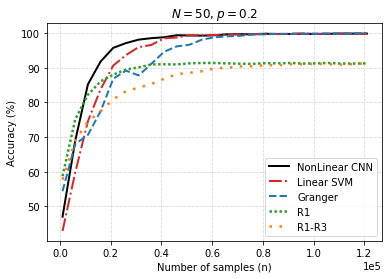

In [7]:
import pprint, pickle
import numpy as np
import matplotlib.pyplot as plt

step=5000
x = np.arange(min_samples,tsize,step=step)
data_plot = np.zeros((data.shape[0],5))
for i in range(data.shape[0]):
    data_plot[i,:] = np.mean(data[i,:,0:5],axis=0)

fig=plt.figure()
plt.grid(alpha=0.5,linestyle='--')
ni=0
nx=len(x)
plt.plot(x[ni:nx],data_plot[ni:nx,4],color='k',linestyle='-',linewidth=2)
plt.plot(x[ni:nx],data_plot[ni:nx,3],color='tab:red',linestyle='-.',linewidth=2)
plt.plot(x[ni:nx],data_plot[ni:nx,0],color='tab:blue',linestyle='--',linewidth=2)
plt.plot(x[ni:nx],data_plot[ni:nx,2],color='tab:green',linestyle=':', dashes=(1,1),linewidth=2.5)
plt.plot(x[ni:nx],data_plot[ni:nx,1],color='tab:orange',linestyle=':',dashes=(1,3),linewidth=2.5)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title(r'$N=50, p=0.2$')
plt.ylabel("Accuracy (%)")
plt.xlabel("Number of samples (n)")
plt.legend(["NonLinear CNN", "Linear SVM","Granger","R1","R1-R3"],loc=4)

### Cluster Variance

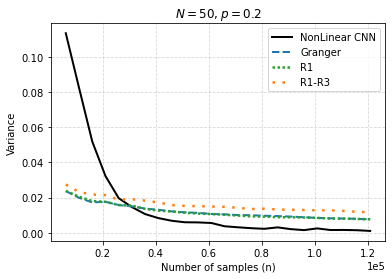

In [8]:
data_plot = np.zeros((data.shape[0],5))
for i in range(data.shape[0]):
    data_plot[i,0] = np.mean(data[i,:,6],axis=0)
    data_plot[i,1] = np.mean(data[i,:,7],axis=0)
    data_plot[i,2] = np.mean(data[i,:,8],axis=0)
    data_plot[i,3] = np.mean(data[i,:,10],axis=0)

fig=plt.figure()
plt.grid(alpha=0.5,linestyle='--')
ni=1
nx=len(x)
st=1
plt.plot(x[ni:nx:st],data_plot[ni:nx:st,3],color='k',linestyle='-',linewidth=2)
plt.plot(x[ni:nx:st],data_plot[ni:nx:st,0],color='tab:blue',linestyle='--',linewidth=2)
plt.plot(x[ni:nx:st],data_plot[ni:nx:st,2],color='tab:green',linestyle=':', dashes=(1,1),linewidth=2.5)
plt.plot(x[ni:nx:st],data_plot[ni:nx:st,1],color='tab:orange',linestyle=':',dashes=(1,3),linewidth=2.5)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title(r'$N=50, p=0.2$')
plt.ylabel("Variance")
#plt.xlabel("Time-series dimension (n)")
plt.xlabel("Number of samples (n)")
plt.legend(["NonLinear CNN","Granger","R1","R1-R3"],loc='best')

In [9]:
### Identifiability Gap

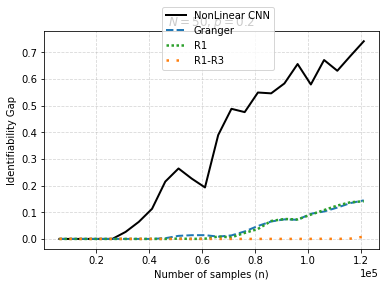

In [10]:
data_plot = np.zeros((data.shape[0],5))
for i in range(data.shape[0]):
    data_plot[i,0] = np.mean(data[i,:,12],axis=0)*2
    data_plot[i,1] = np.mean(data[i,:,13],axis=0)*2
    data_plot[i,2] = np.mean(data[i,:,14],axis=0)*2
    data_plot[i,3] = np.mean(data[i,:,16],axis=0)*2

fig=plt.figure()
plt.grid(alpha=0.5,linestyle='--')
ni=1
nx=len(x)
st=1
plt.plot(x[ni:nx:st],data_plot[ni:nx:st,3],color='k',linestyle='-',linewidth=2)
plt.plot(x[ni:nx:st],data_plot[ni:nx:st,0],color='tab:blue',linestyle='--',linewidth=2)
plt.plot(x[ni:nx:st],data_plot[ni:nx:st,2],color='tab:green',linestyle=':', dashes=(1,1),linewidth=2.5)
plt.plot(x[ni:nx:st],data_plot[ni:nx:st,1],color='tab:orange',linestyle=':',dashes=(1,3),linewidth=2.5)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title(r'$N=50, p=0.2$')
plt.ylabel("Identifiability Gap")
#plt.xlabel("Time-series dimension (n)")
plt.xlabel("Number of samples (n)")
plt.legend(["NonLinear CNN","Granger","R1","R1-R3"],loc='best',bbox_to_anchor=(0.7,0.8))